# Matlab testbench model state-space matrices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import scipy.linalg as LA
from scipy.signal import lsim, dlsim
import opentorsion as ot
import cvxpy as cp

In [2]:
plt.style.use(['science', 'ieee'])
plt.rcParams["figure.figsize"] = (6,4)

Here we build the continuous state-space model as described in the MSSP article using the parameters listed in the article.

In [3]:
inertias = np.array([7.94e-4,
            3.79e-6,
            3.00e-6,
            2.00e-6,
            7.81e-3,
            2.00e-6,
            3.17e-6,
            5.01e-5,
            6.50e-6,
            5.65e-5,
            4.27e-6,
            3.25e-4,
            1.20e-4,
            1.15e-5,
            1.32e-4,
            4.27e-6,
            2.69e-4,
            1.80e-4,
            2.00e-5,
            2.00e-4,
            4.27e-6,
            4.95e-2])

stiffnesses = np.array([1.90e5,
               6.95e3,
               90.00,
               90.00,
               90.00,
               90.00,
               30.13,
               4.19e4,
               5.40e3,
               4.19e4,
               1.22e3,
               4.33e4,
               3.10e4,
               1.14e3,
               3.10e4,
               1.22e4,
               4.43e4,
               1.38e5,
               2.00e4,
               1.38e5,
               1.22e4])

damping = np.array([8.08,
           0.29,
           0.24,
           0.24,
           0.24,
           0.24,
           0.00,
           1.78,
           0.23,
           1.78,
           0.52,
           1.84,
           1.32,
           0.05,
           1.32,
           0.52,
           1.88,
           5.86,
           0.85,
           5.86,
           0.52])


external_damping = np.array([0.0030,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0.0031,
                    0,
                    0,
                    0,
                    0,
                    0.0031,
                    0,
                    0,
                    0,
                    0,
                    0.2400])

gear_ratios = np.array([1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1/3,
               1,
               1,
               1,
               1,
               1/4,
               1,
               1,
               1,
               1])

In [4]:
def state_space_matrices(inertia, stiff, damp, damp_ext, ratios):
    cn = damp*ratios
    cn2 = damp*ratios**2
    cn2 = np.hstack((cn2, 0))
    c0 = np.copy(damp)
    c0 = np.insert(c0, 0, 0, axis=0)
    cn2d = -(c0 + cn2 + damp_ext)
    
    A11 = (np.diag(cn2d) + np.diag(cn, k=1) + np.diag(cn, k=-1)) / inertia.reshape(inertia.shape[0], 1)
    
    ks = -np.hstack((stiff, 0))
    A12 = np.delete((np.diag(ks) + np.diag(stiff, k=-1)) / inertia.reshape(inertia.shape[0], 1), -1, axis=1)
    
    
    A23 = np.delete(np.diag(np.hstack((ratios, 0))) + np.diag(-np.ones(len(ratios)), k=1), -1, axis=0)
    
    A = np.vstack((np.hstack((A11, A12)), np.hstack((A23, np.zeros((A23.shape[0], A23.shape[1]-1))))))
    
    B = np.zeros((A.shape[0], 2))
    B[0,0] += 1/inertia[0]
    B[len(inertia)-1, 1] -= 1/inertia[-1]
    
    C = np.zeros((3, A.shape[0]))
    C[0,6] += 1
    C[1,7] += 1
    C[2,30] += 5400
    D = np.zeros((C.shape[0], B.shape[1]))
    
    return A, B, C, D

In [5]:
Ac, Bc, C, D = state_space_matrices(inertias, stiffnesses, damping, external_damping, gear_ratios)

In [6]:
def c2d(A, B, Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    
    return Ad, Bd

Here we have, for comparison, the continuous state-space matrices (A, B, C, D) got from the matlab model used in the MSSP article. The matrices are loaded from .csv files.

In [7]:
def get_matlab_matrices():
    A = np.genfromtxt('../../data/testbench_models/MSSP_new/tb_A.csv', delimiter=',')
    B = np.genfromtxt('../../data/testbench_models/MSSP_new/tb_B.csv', delimiter=',')
    C = np.genfromtxt('../../data/testbench_models/MSSP_new/tb_C.csv', delimiter=',')
    D = np.genfromtxt('../../data/testbench_models/MSSP_new/tb_D.csv', delimiter=',')
    
    return A, B, C, D

In [8]:
A_mat, B_mat, C_mat, D_mat = get_matlab_matrices()

# Input and state estimation functions

Here are all the functions for the data equation, regularization matrices and the convex optimization problems.

In [9]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))
    
    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O

In [10]:
def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)
    
    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B, 
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z
        
        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))
        
        # then add the impulse responses
        A_power2 = np.copy(A)
        
        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))
            
        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))
        
        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1
    
    return gamma

In [11]:
def L(input_shape):
    '''
    The regularization matrix L.

    Parameters:

    input_shape : float
        Input vector shape used to determine L matrix shape.

    Returns:

    L : ndarray
        The regularization matrix
    '''
    I = np.eye(input_shape)
    L = -I + np.diag(np.ones(input_shape-1), 1)

    return I

In [12]:
def second_difference_matrix(n, m):
    D2 = np.eye(n*m) - 2*np.eye(n*m, k=2) + np.eye(n*m, k=4)
    
    # delete incomplete rows
    D2 = D2[:-2*m, :]
    
    return D2

In [13]:
def tikhonov_problem(meas, obsrv, gamm, regu, initial_state=None, lam=1, cmplx=False):
    '''
    This function uses the cvxpy library to solve a Tikhonov regularization problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)
    
    if initial_state is None:
        x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    else:
        x = initial_state
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.sum_squares(regu @ d))
    
    prob = cp.Problem(objective)
    prob.solve()

    if initial_state is None:
        x_value = x.value
    else:
        x_value = initial_state

    return d.value, x_value

In [14]:
def lasso_problem(meas, obsrv, gamm, regu, initial_state=None, lam=1, cmplx=False):
    '''
    This function uses the cvxpy library to solve a LASSO problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)
    
    if initial_state is None:
        x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    else:
        x = initial_state
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.pnorm(regu @ d, 1))
    
    prob = cp.Problem(objective)
    prob.solve()
    
    if initial_state is None:
        x_value = x.value
    else:
        x_value = initial_state

    return d.value, x_value

# Input and state estimation with laboratory testbench measurments

## Load and preprocess data
The data used here is a step load and response for the kongsberg testbench. This data is a snippet of a longer measurement. The length of this data is ~2 seconds.

* sampling rate ~1kHz
* motor torque data is contained in 'step_excitation.csv'
* sensor data is contained in 'step_response.csv' (every third value of the actual measurements were stored in this dataset)

In [15]:
# time (s) | MotorTorque (Nm) | PropellerTorque (Nm)
motor_data = np.genfromtxt('../../data/step/step_excitation.csv', delimiter=',')

# time (s) | enc1_speed (rad/s) | enc2_speed (rad/s) | enc3_speed (rad/s) | enc4_speed (rad/s) | enc5_speed (rad/s) | Torque_transducer1 (Nm) | Torq_transducer2 (Nm)
sensor_data = np.genfromtxt('../../data/step/step_response.csv', delimiter=',')
# the speed values were calculated from the angular values and timesteps of the encoder data using np.gradient()

In [16]:
t_motor = motor_data[:,0]
tau_motor = motor_data[:,1]
tau_propeller = motor_data[:,2]

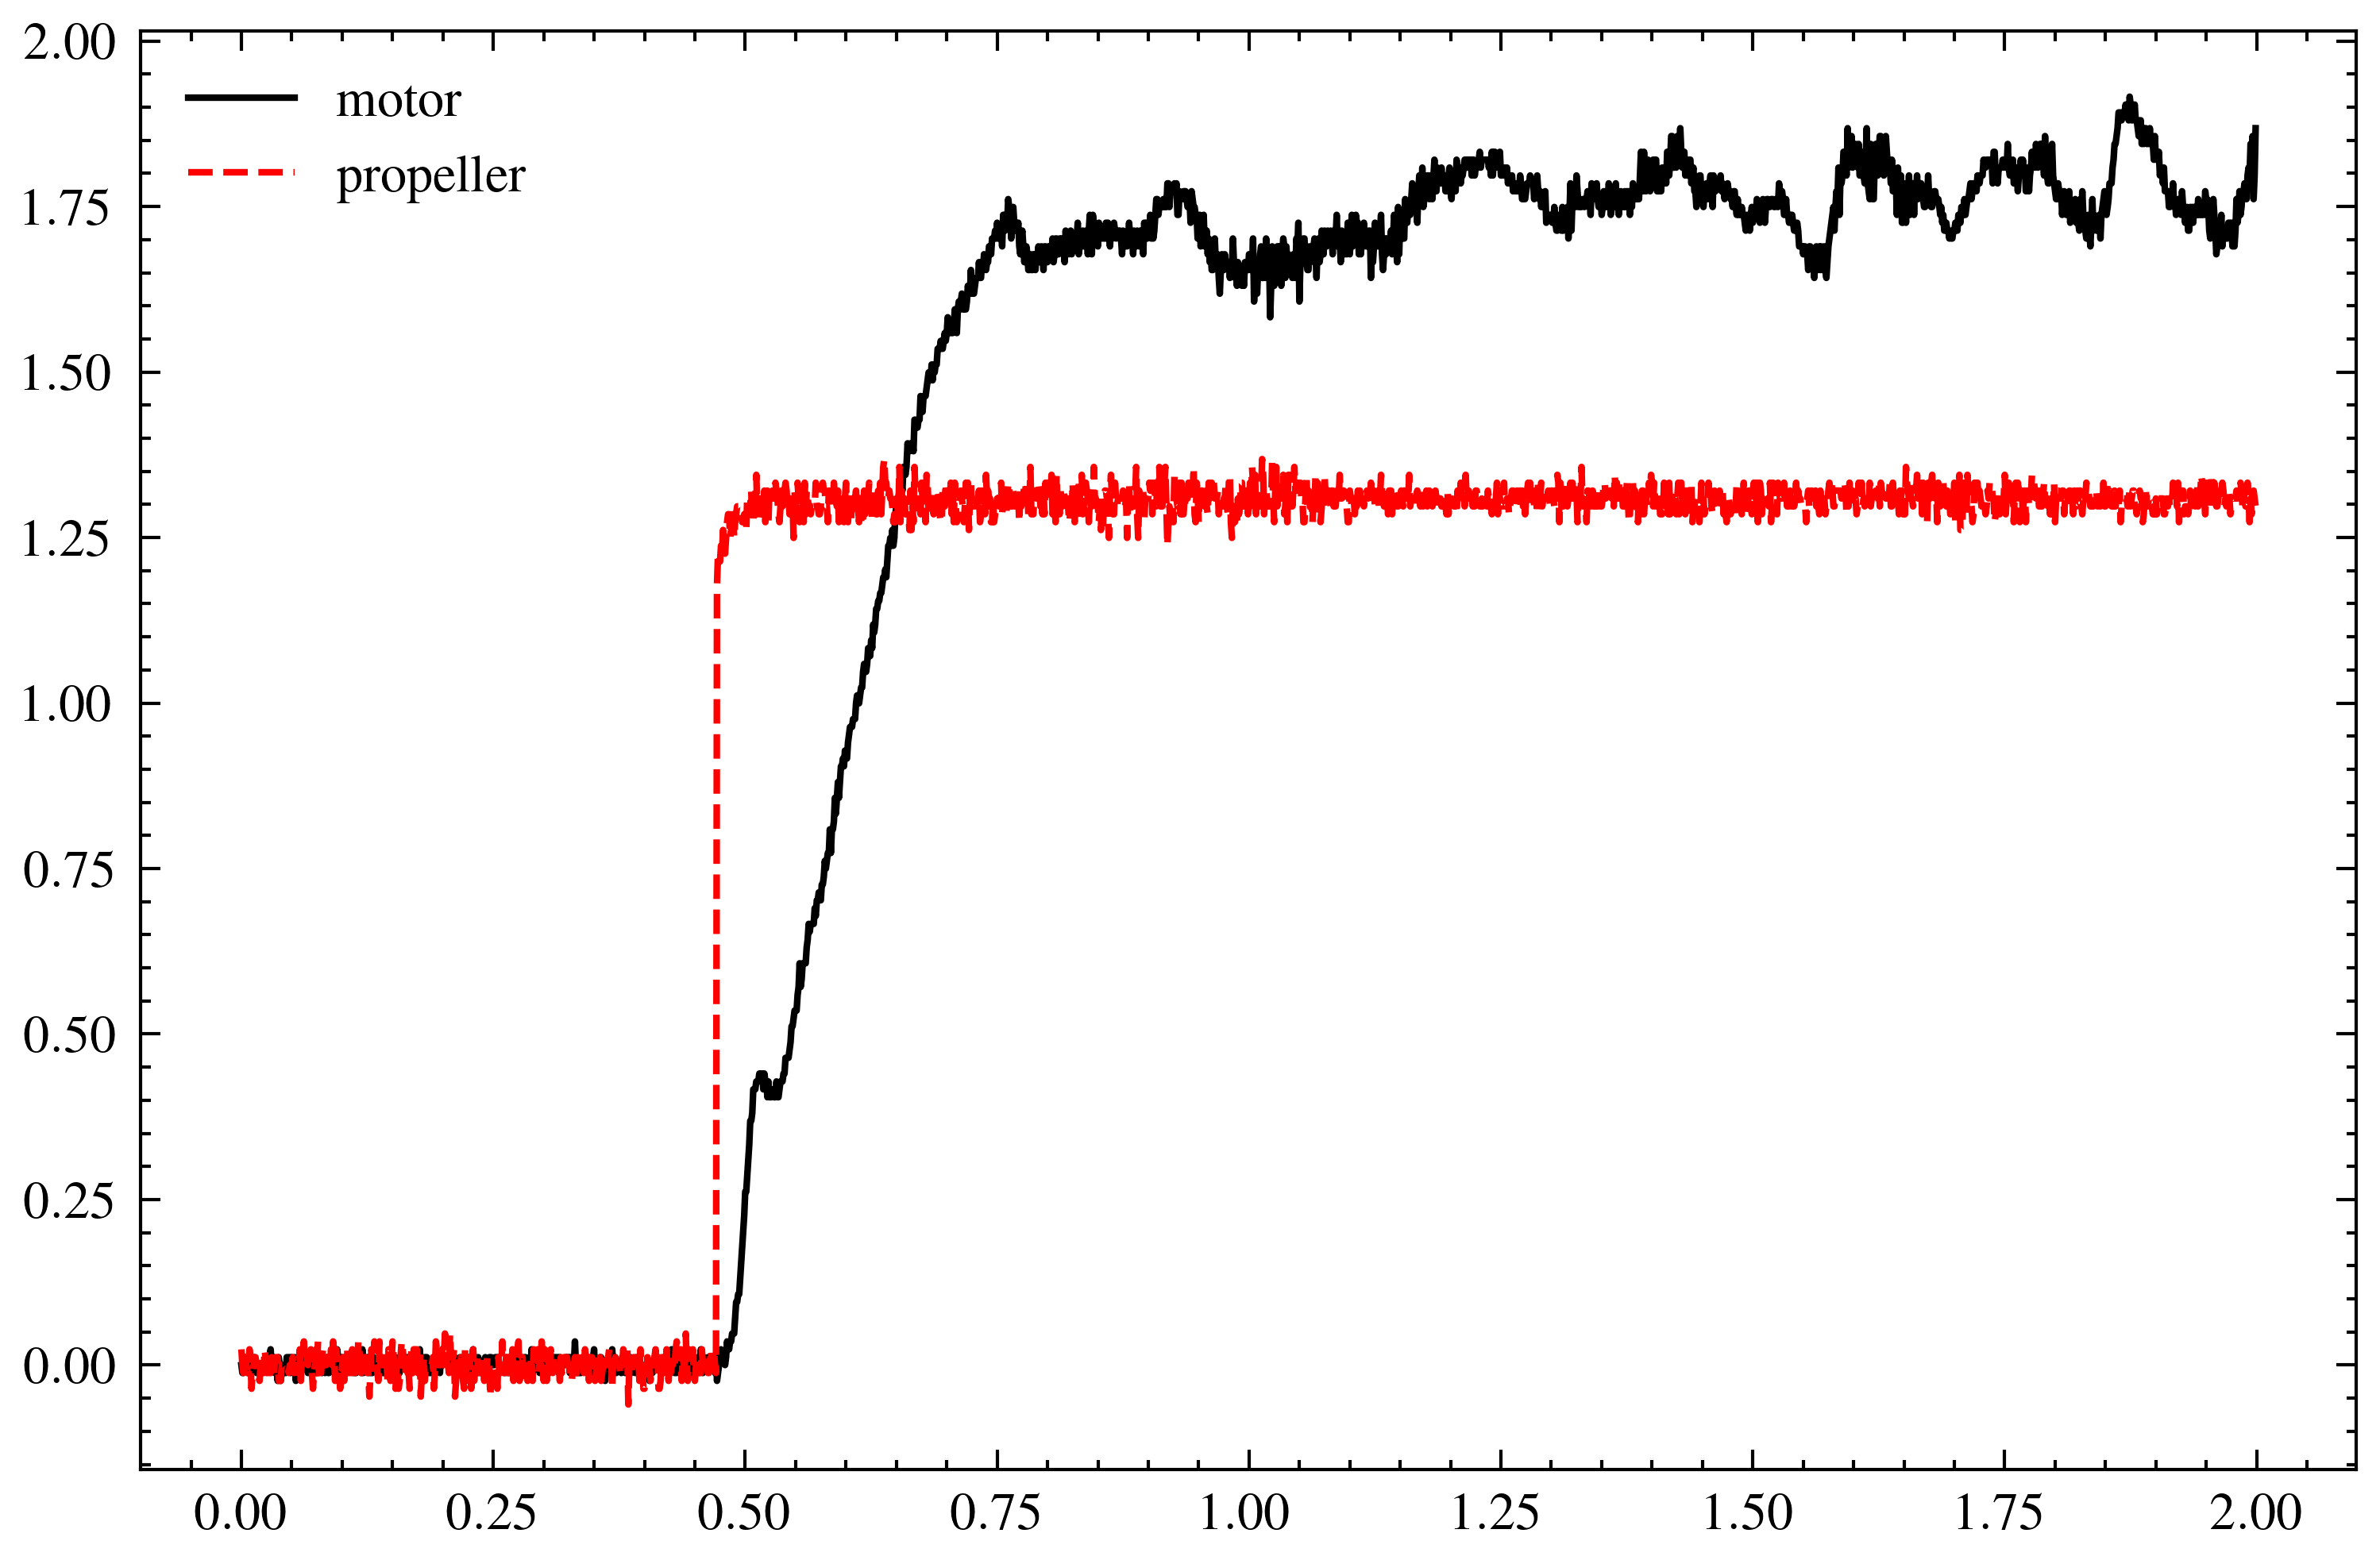

In [17]:
plt.plot(t_motor, tau_motor, label='motor')
plt.plot(t_motor, tau_propeller, label='propeller')
plt.legend()
plt.show()

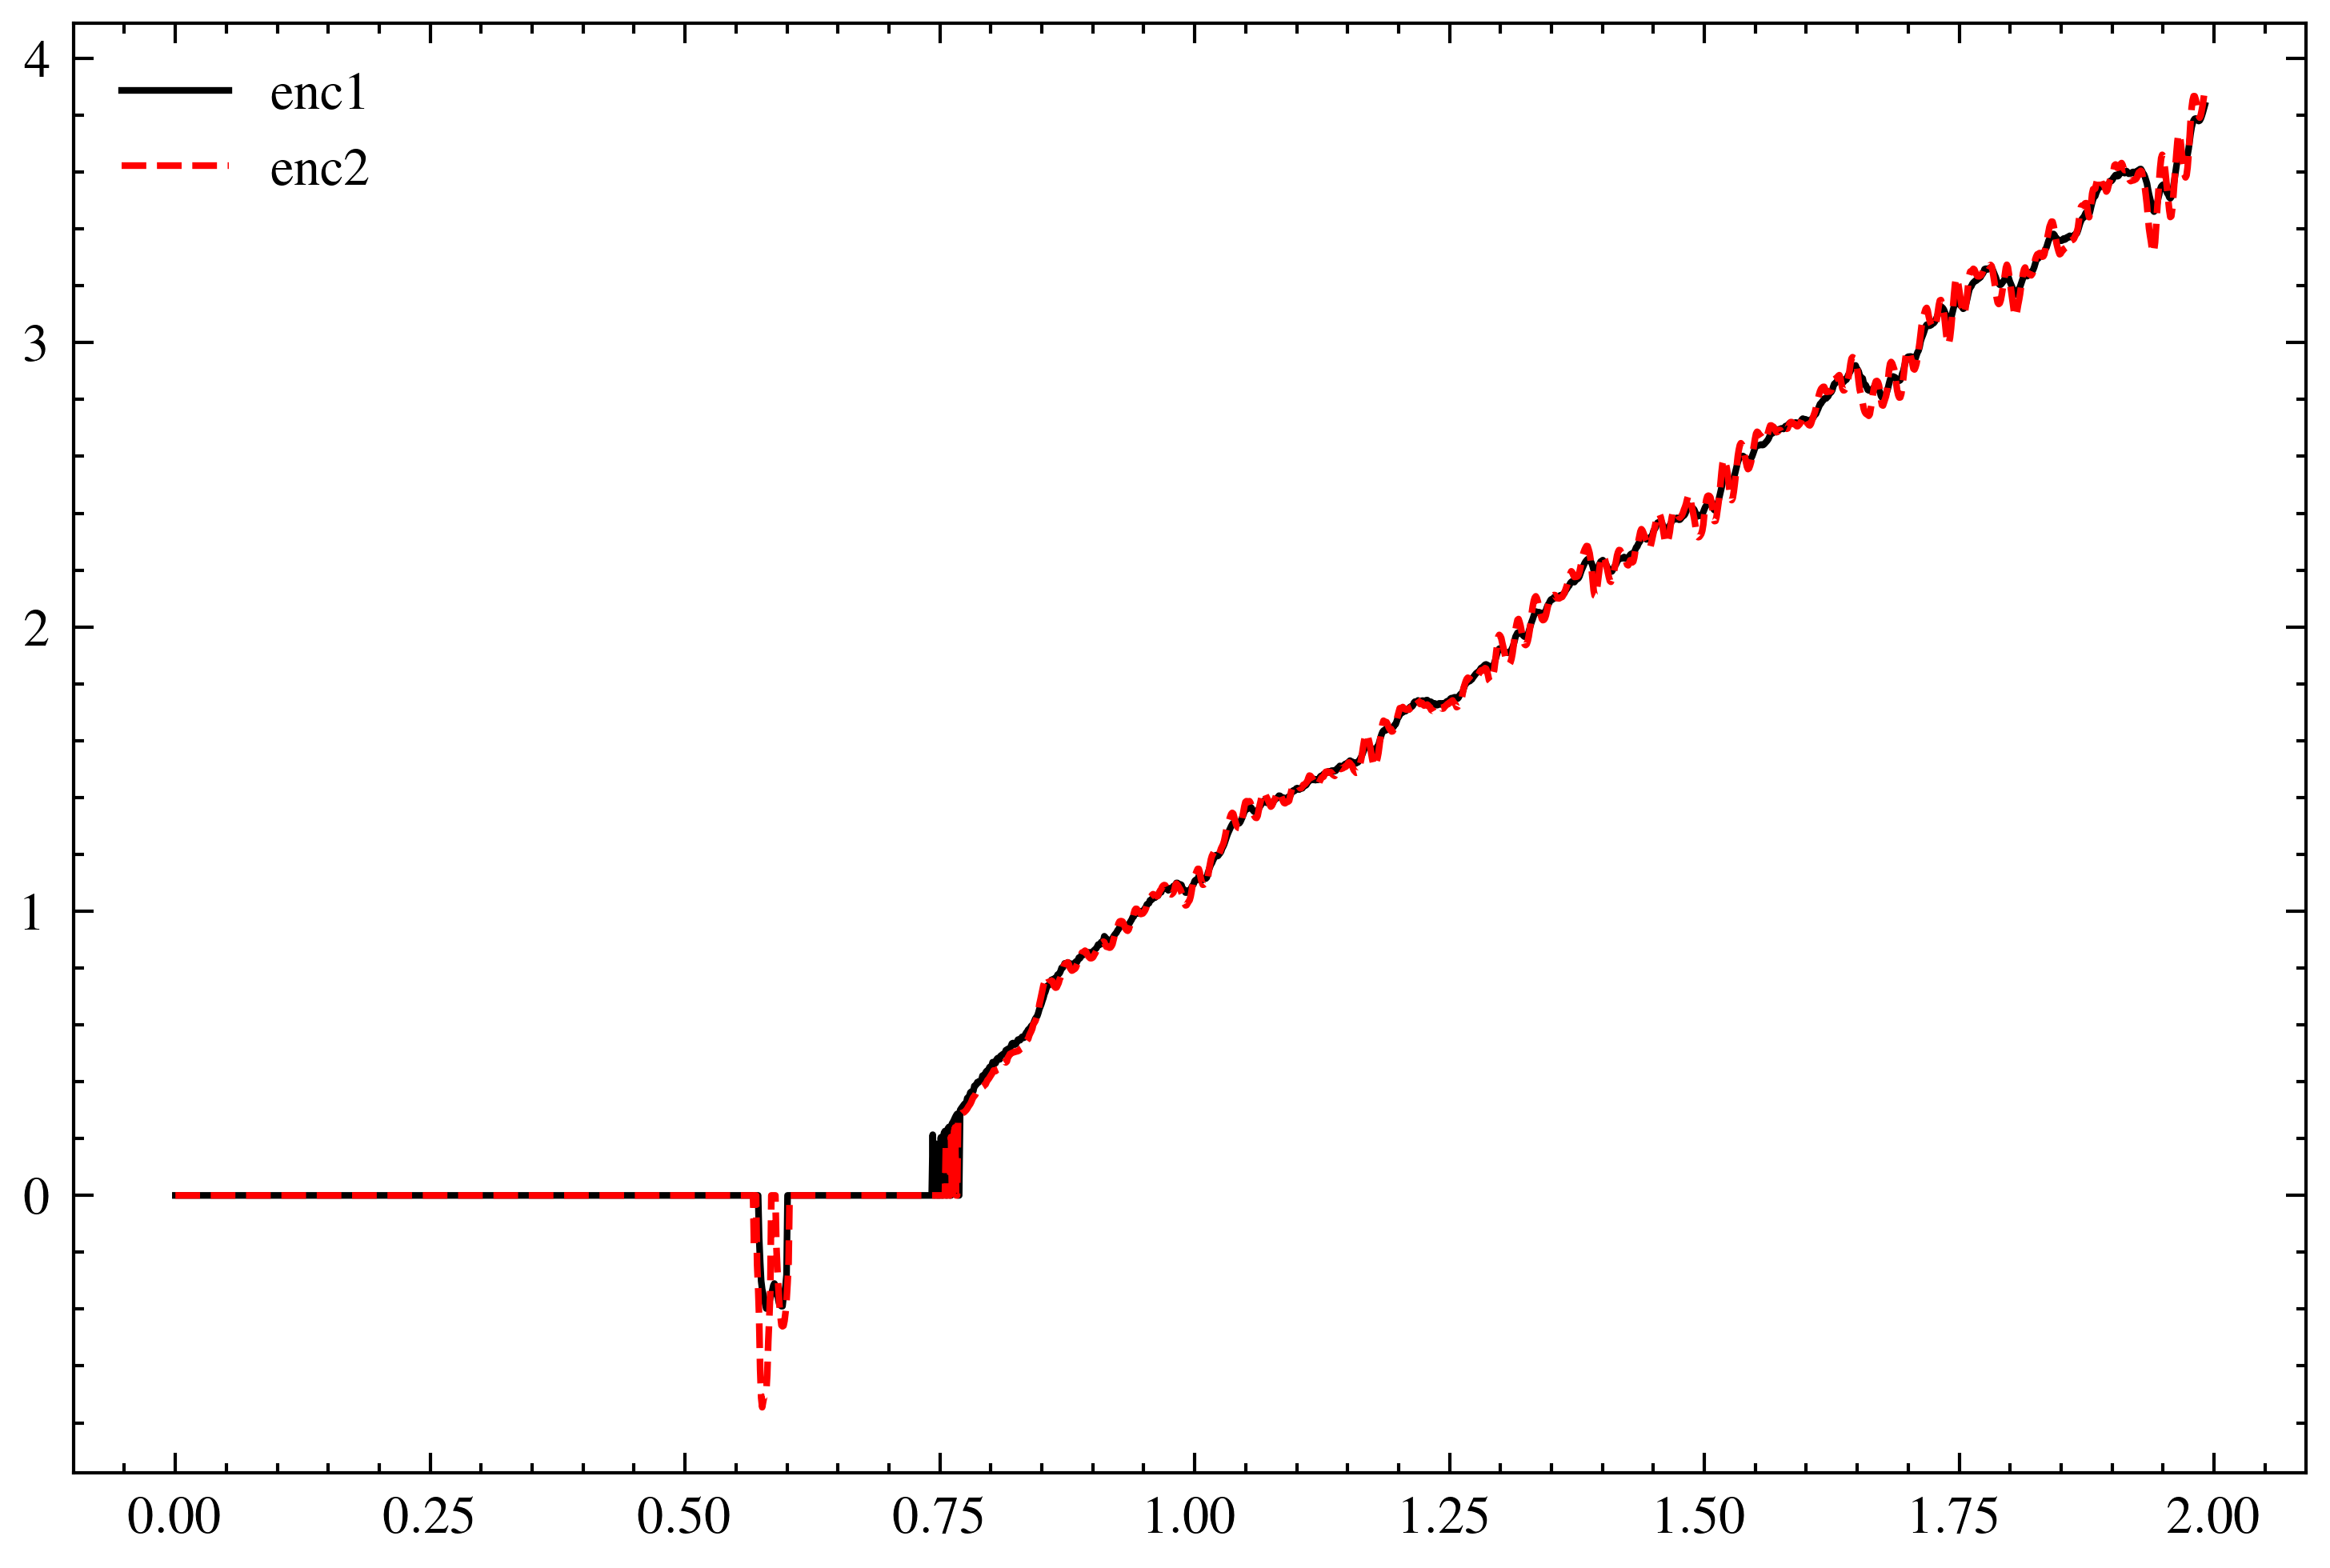

In [18]:
t_sensor = sensor_data[:,0]
omega1 = sensor_data[:,1]
omega2 = sensor_data[:,2]
omega3 = sensor_data[:,3]
omega4 = sensor_data[:,4]
omega5 = sensor_data[:,5]
torq1 = sensor_data[:,6]
torq2 = sensor_data[:,7]
plt.plot(t_sensor, omega1, label='enc1')
plt.plot(t_sensor, omega2, label='enc2')
#plt.plot(t_sensor, omega3, label='enc3')
#plt.plot(t_sensor, omega4, label='enc4')
#plt.plot(t_sensor, omega5, label='enc5')
plt.legend()
plt.show()

# Simulation with measured inputs

The continuous state-space matrices A and B are discretized with the function c2d().
The scipy.signal.dlsim function is used to simulate the discrete state-space system with the measured motor and propeller loads. The simulation results are compared to the experimental measurements.

In [19]:
dt = np.mean(np.diff(t_motor))
motor_loads = np.vstack((tau_motor, tau_propeller)).T

A_mat_d, B_mat_d = c2d(A_mat, B_mat, dt)
Ad, Bd = c2d(Ac, Bc, dt)

In [20]:
t_out, y_out, x_out = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, dt), t=t_motor, u=motor_loads)
tout, yout, xout = dlsim((Ad, Bd, C, D, dt), t=t_motor, u=motor_loads)

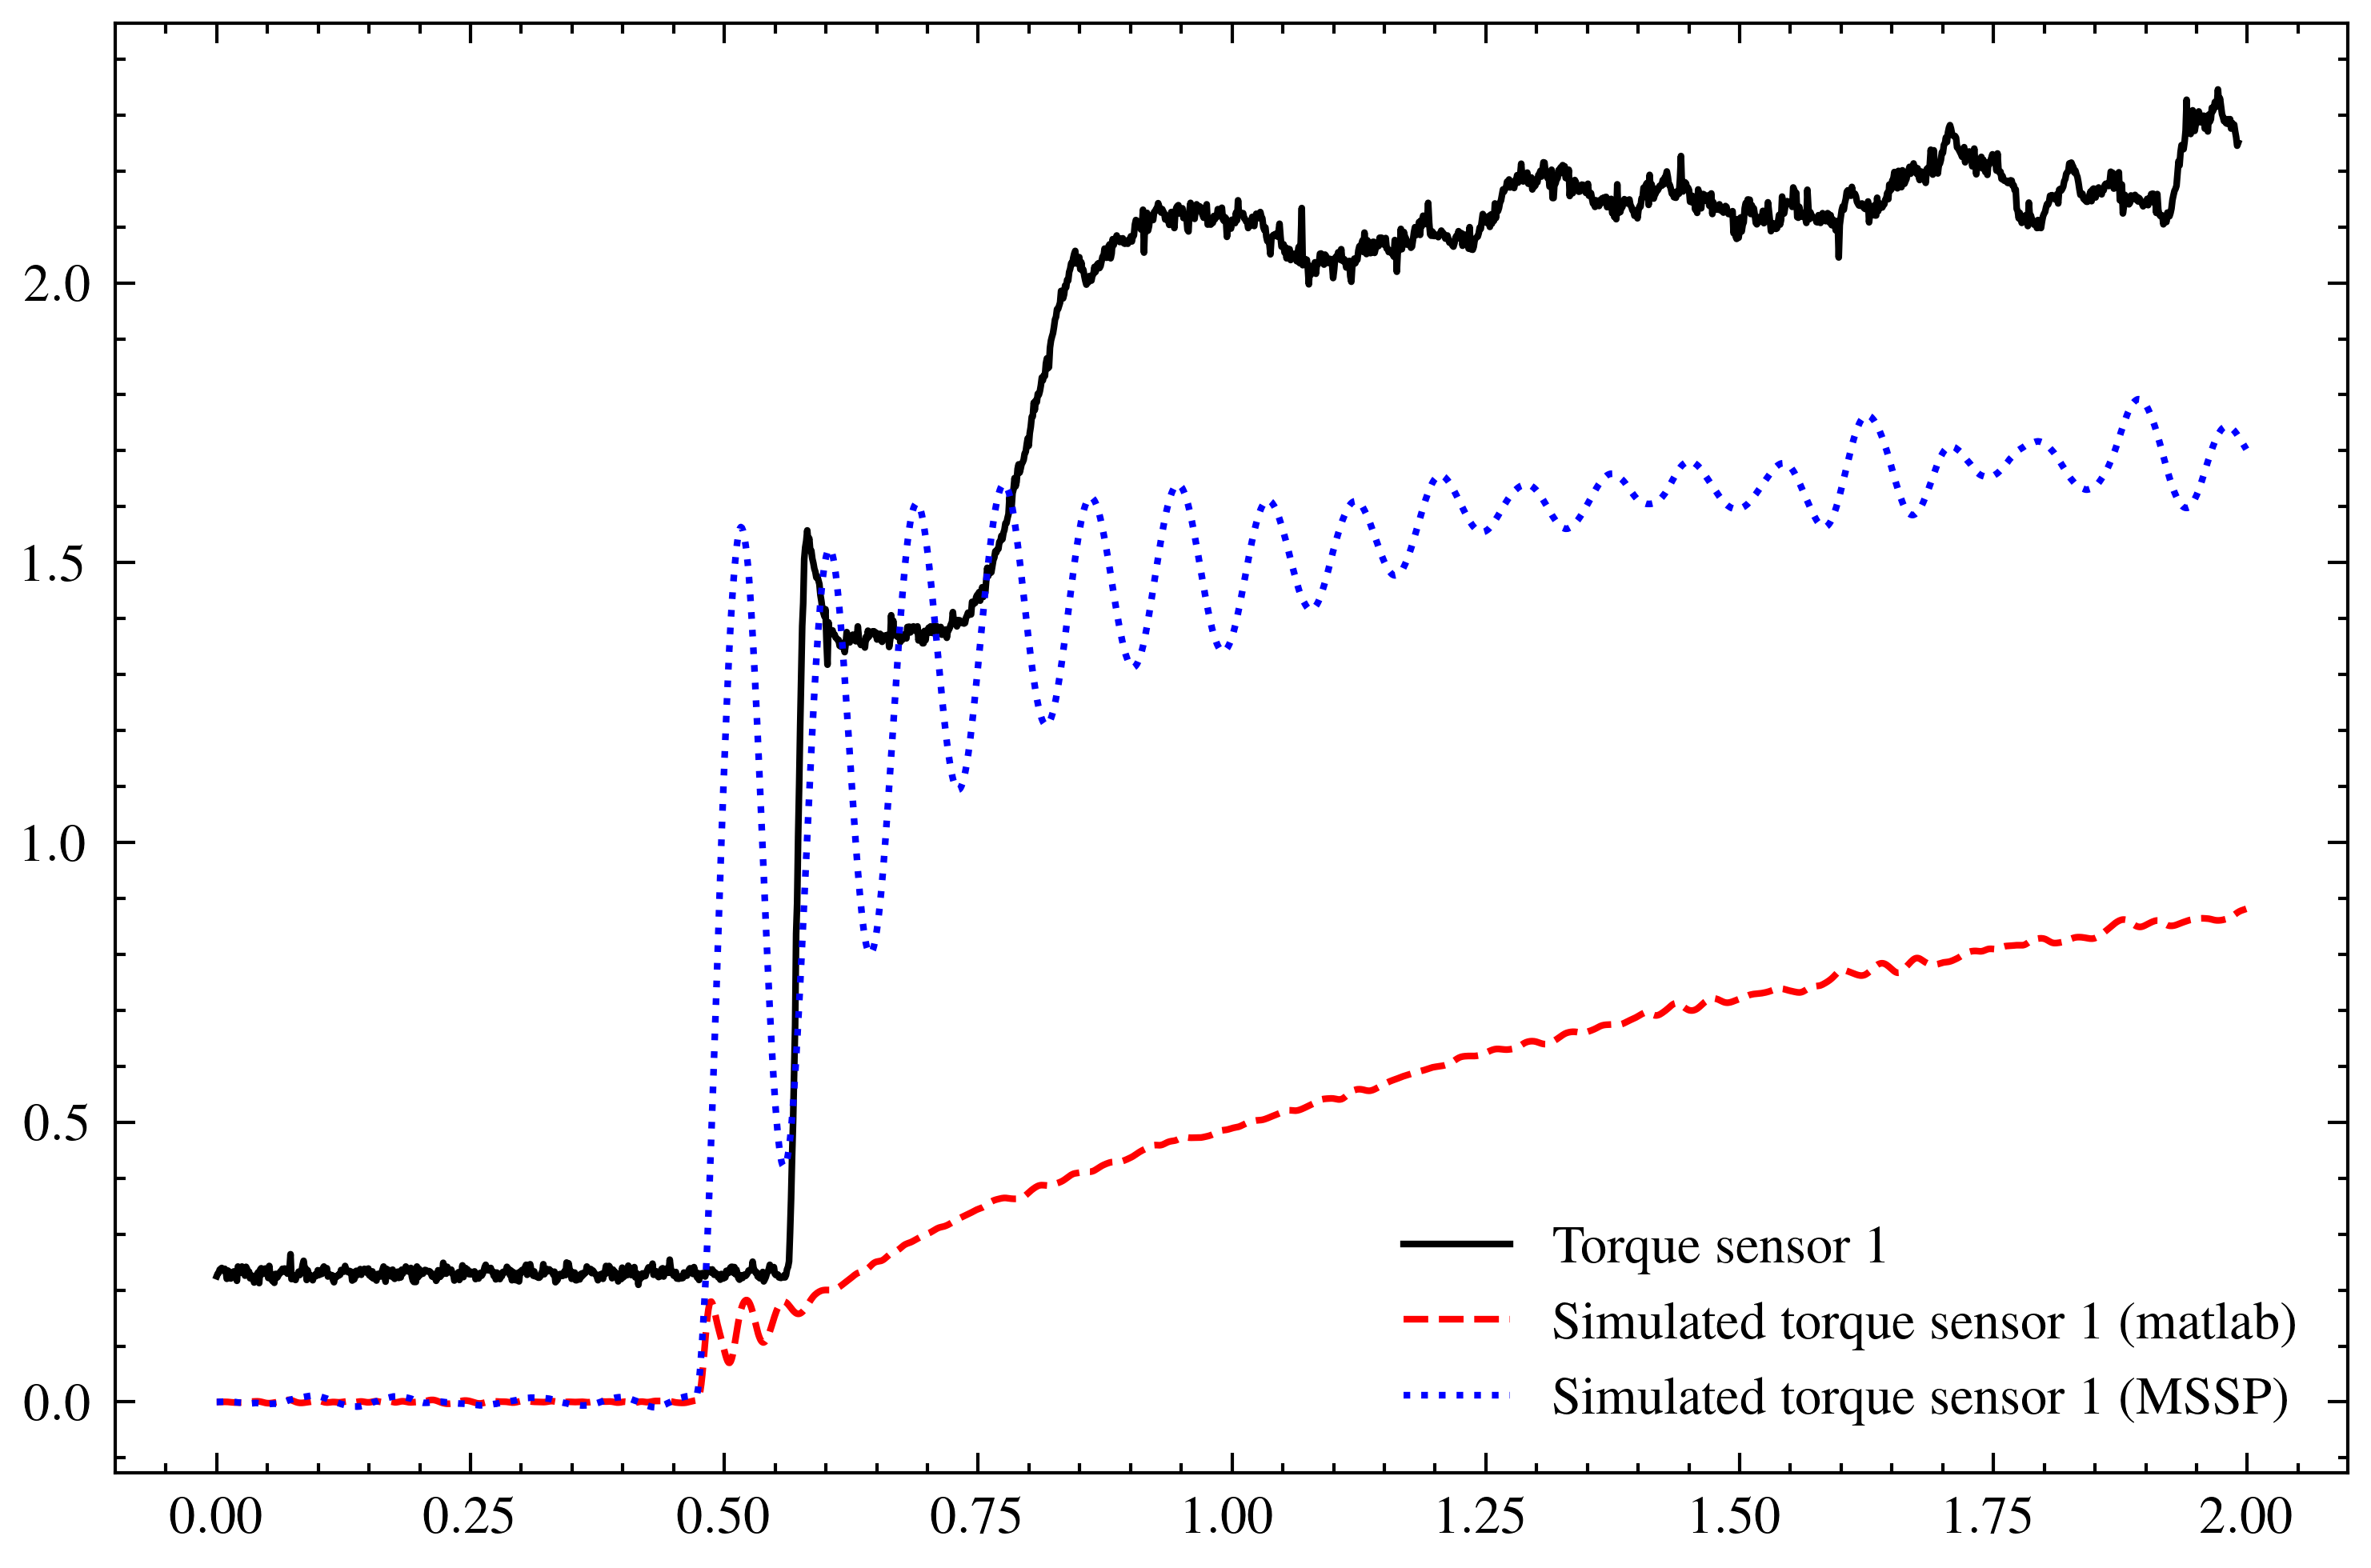

In [21]:
plt.plot(t_sensor, torq1, label='Torque sensor 1')
#plt.plot(t_sensor_third, torq2, label='Torque sensor 2', alpha=0.5)
plt.plot(t_out, y_out[:,-1], label='Simulated torque sensor 1 (matlab)')
plt.plot(tout, yout[:,-1], label='Simulated torque sensor 1 (MSSP)')
plt.legend()
plt.show()

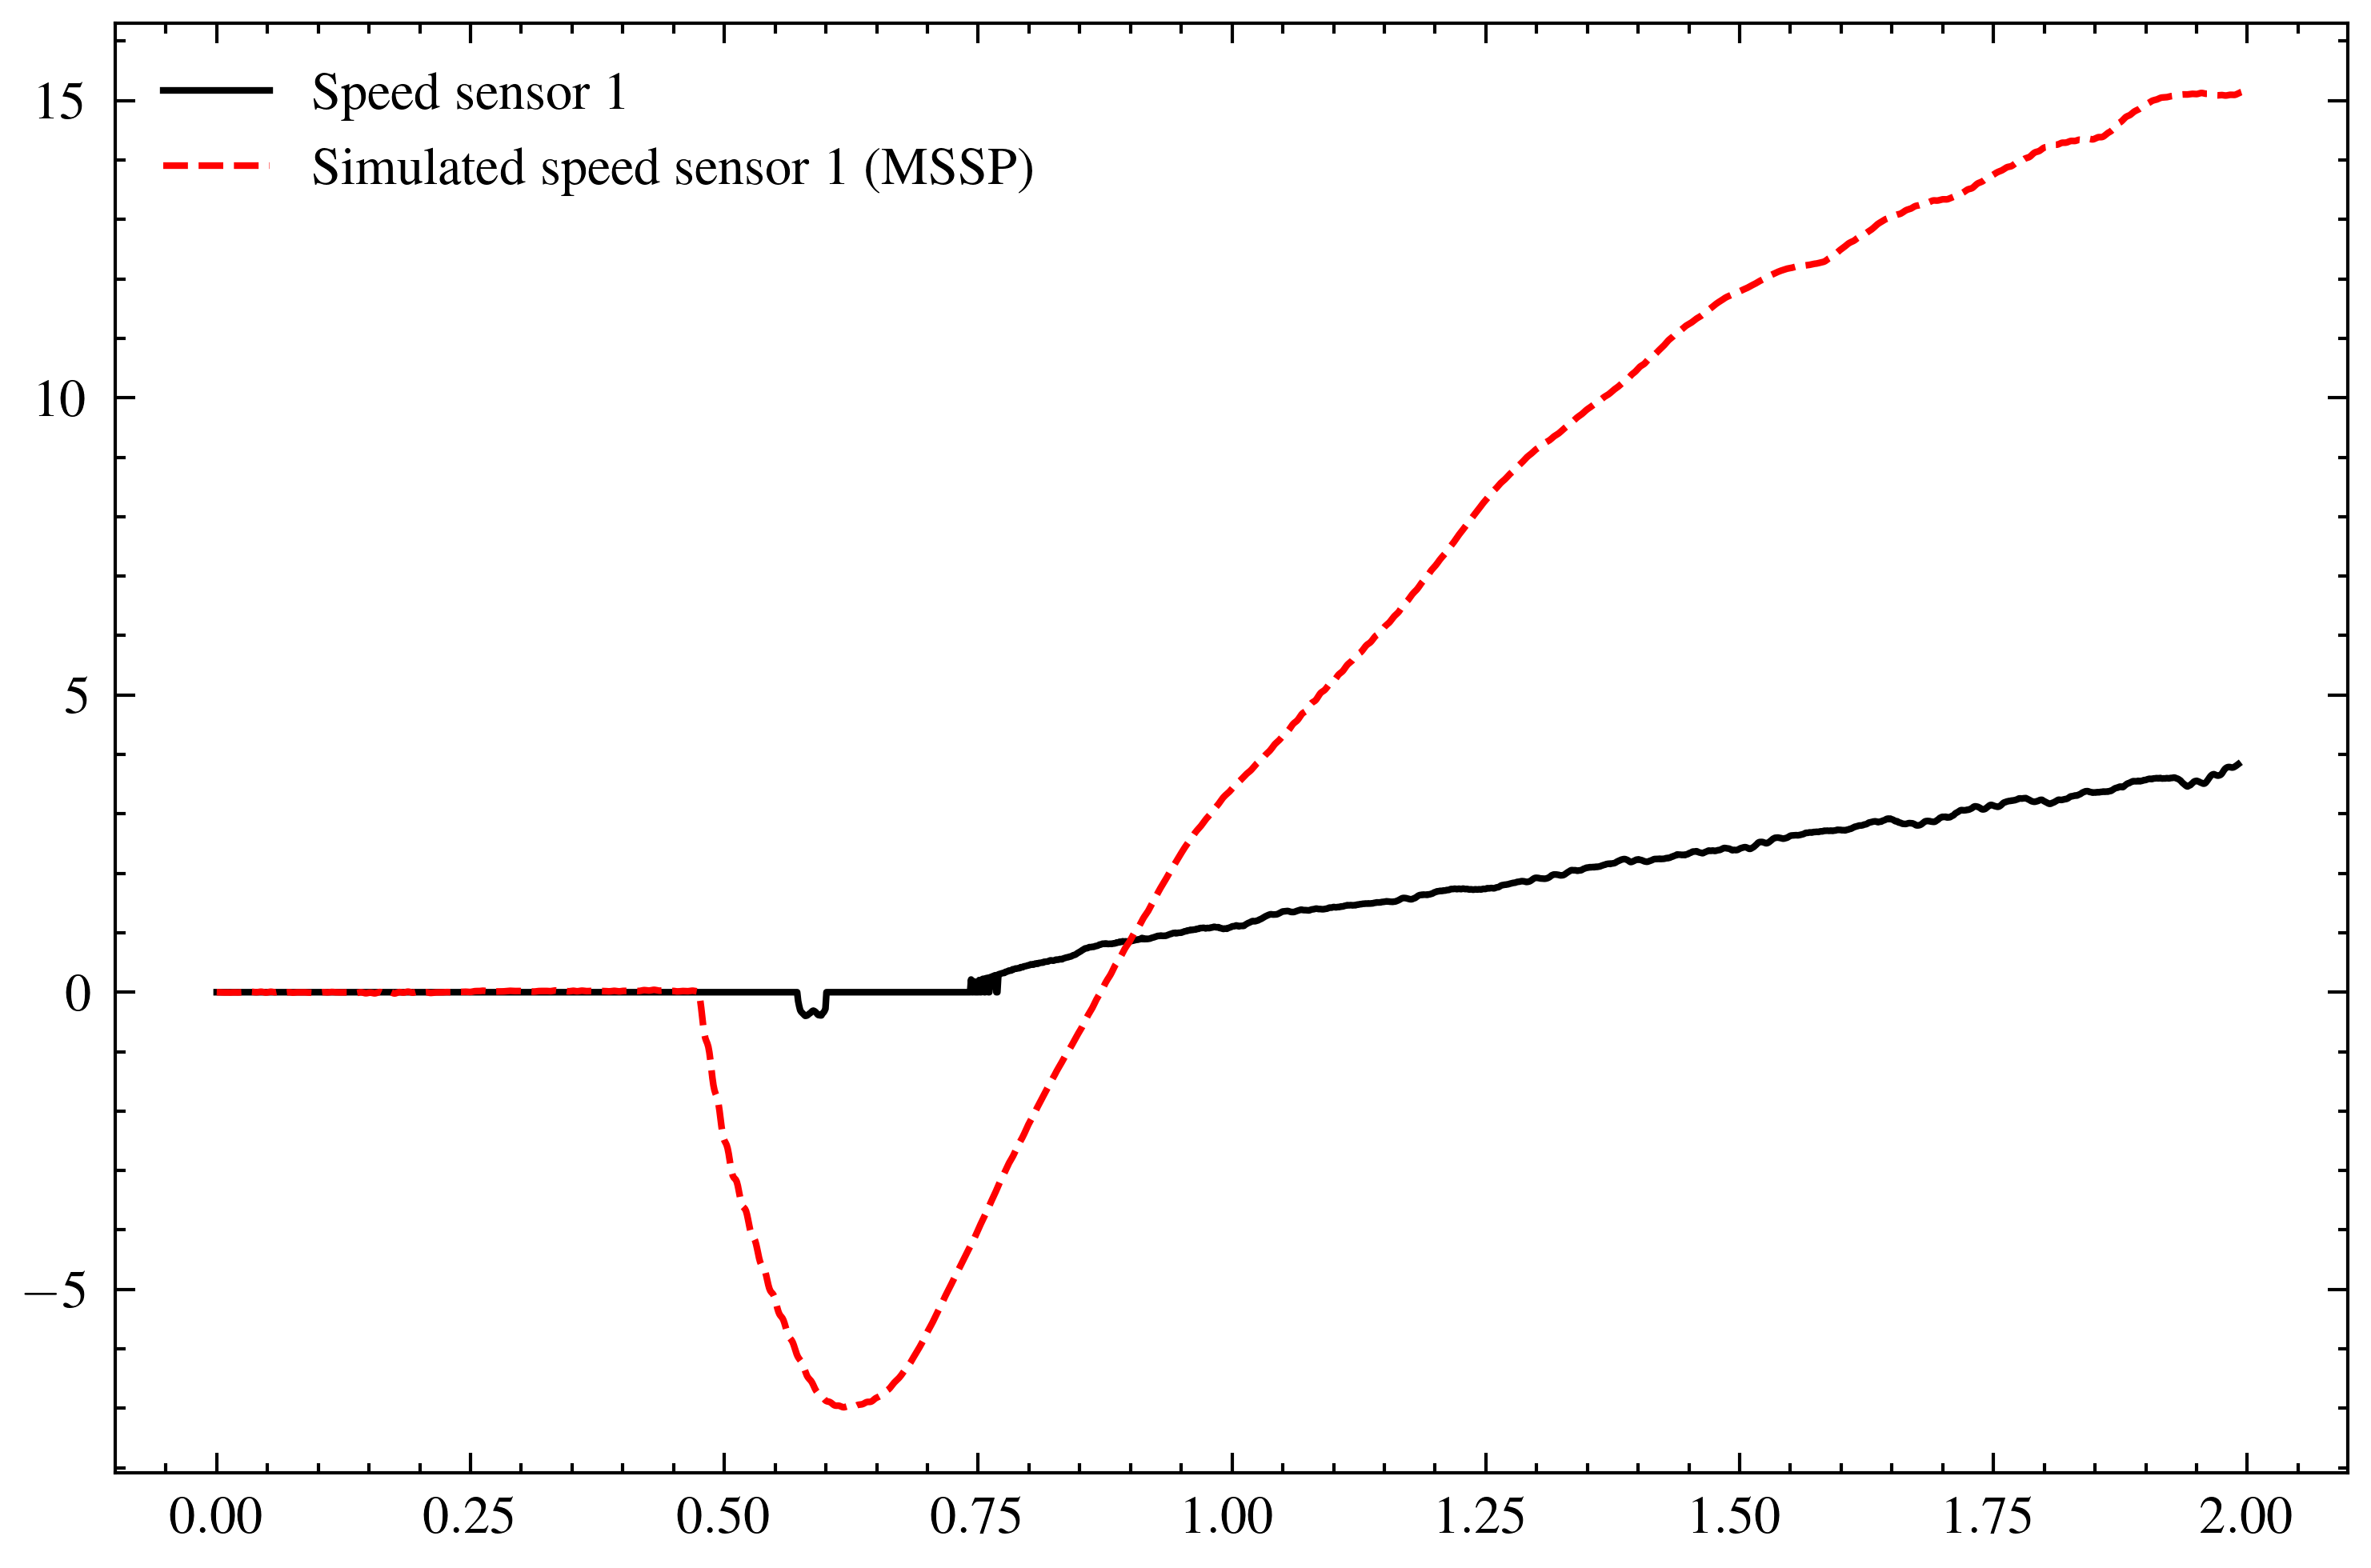

In [30]:
plt.plot(t_sensor, omega1, label='Speed sensor 1')
#plt.plot(t_out, y_out[:,0], label='Simulated speed sensor 1 (matlab)')
plt.plot(tout, yout[:,0], label='Simulated speed sensor 1 (MSSP)')
plt.legend()
plt.show()

## Input estimation

Here we use the speed data from encoders 1 and 2 and the torque data from torque transducer 1 (similar to the MSSP article). Additionally, the driving motor data is assumed to be equal to the torque in the first shaft.

In [23]:
measurements_noise = np.vstack((omega1, omega2, tau_motor, torq1)).T
print(measurements_noise.shape)

(2000, 4)


The C matrix here is the same as in the matlab model, however, an additional row is included for the torque measurement of the first shaft (see above).

In [24]:
c_mat = np.insert(C, 2, np.zeros((1, C.shape[1])), 0)
c_mat[2,22] += 1.9e5
print(c_mat.shape)

(4, 43)


Here the parameters and matrices for the convex optimization problem are defined.

In [25]:
m = Bd.shape[1]
n = len(t_sensor)

bs = 500 # batch size
loop_len = int(n/bs)

D2_mat = second_difference_matrix(bs, m)
L_mat = L(bs*m)
O_mat = O(Ad, c_mat, bs)
G_mat = gamma(Ad, Bd, c_mat, bs)
x_tikhonov = np.zeros((O_mat.shape[1], 1))
x_lasso = np.zeros((O_mat.shape[1], 1))

tikh_estimates = []
lasso_estimates = []

These matrices below are used to calculate the response of the system (using the data equation matrices).
In the loop further below, they are used to calculate a new state-estimate for the convex optimization problem using the previous initial state estimate and the previously estimated input.
This is a naive (and probably computationally inefficient) method for the state-estimation but easy to implement.

In [26]:
# for initial state estimation
C_full = np.eye(Bd.shape[0])
omat = O(Ad, C_full, bs)
gmat = gamma(Ad, Bd, C_full, bs)

In [27]:
for i in range(loop_len):
    batch = measurements_noise[i*bs:(i+1)*bs,:]
    y_noise = batch.reshape(-1,1)
    
    tikhonov_estimate, x_tikhonov = tikhonov_problem(y_noise, O_mat, G_mat, D2_mat, initial_state=x_tikhonov, lam=0.05)
    lasso_estimate, x_lasso = lasso_problem(y_noise, O_mat, G_mat, D2_mat, initial_state=x_lasso, lam=0.05)
    
    x_est_t = omat @ x_tikhonov + gmat @ tikhonov_estimate
    x_tikhonov = x_est_t[-Ad.shape[0]:,:]
    
    x_est_l = omat @ x_lasso + gmat @ lasso_estimate
    x_lasso = x_est_l[-Ad.shape[0]:,:]
    
    tikh_estimates.append(tikhonov_estimate)
    lasso_estimates.append(lasso_estimate)

Here we plot the real input and estimates of the tikhonov and lasso methods with H-P trend filtering.

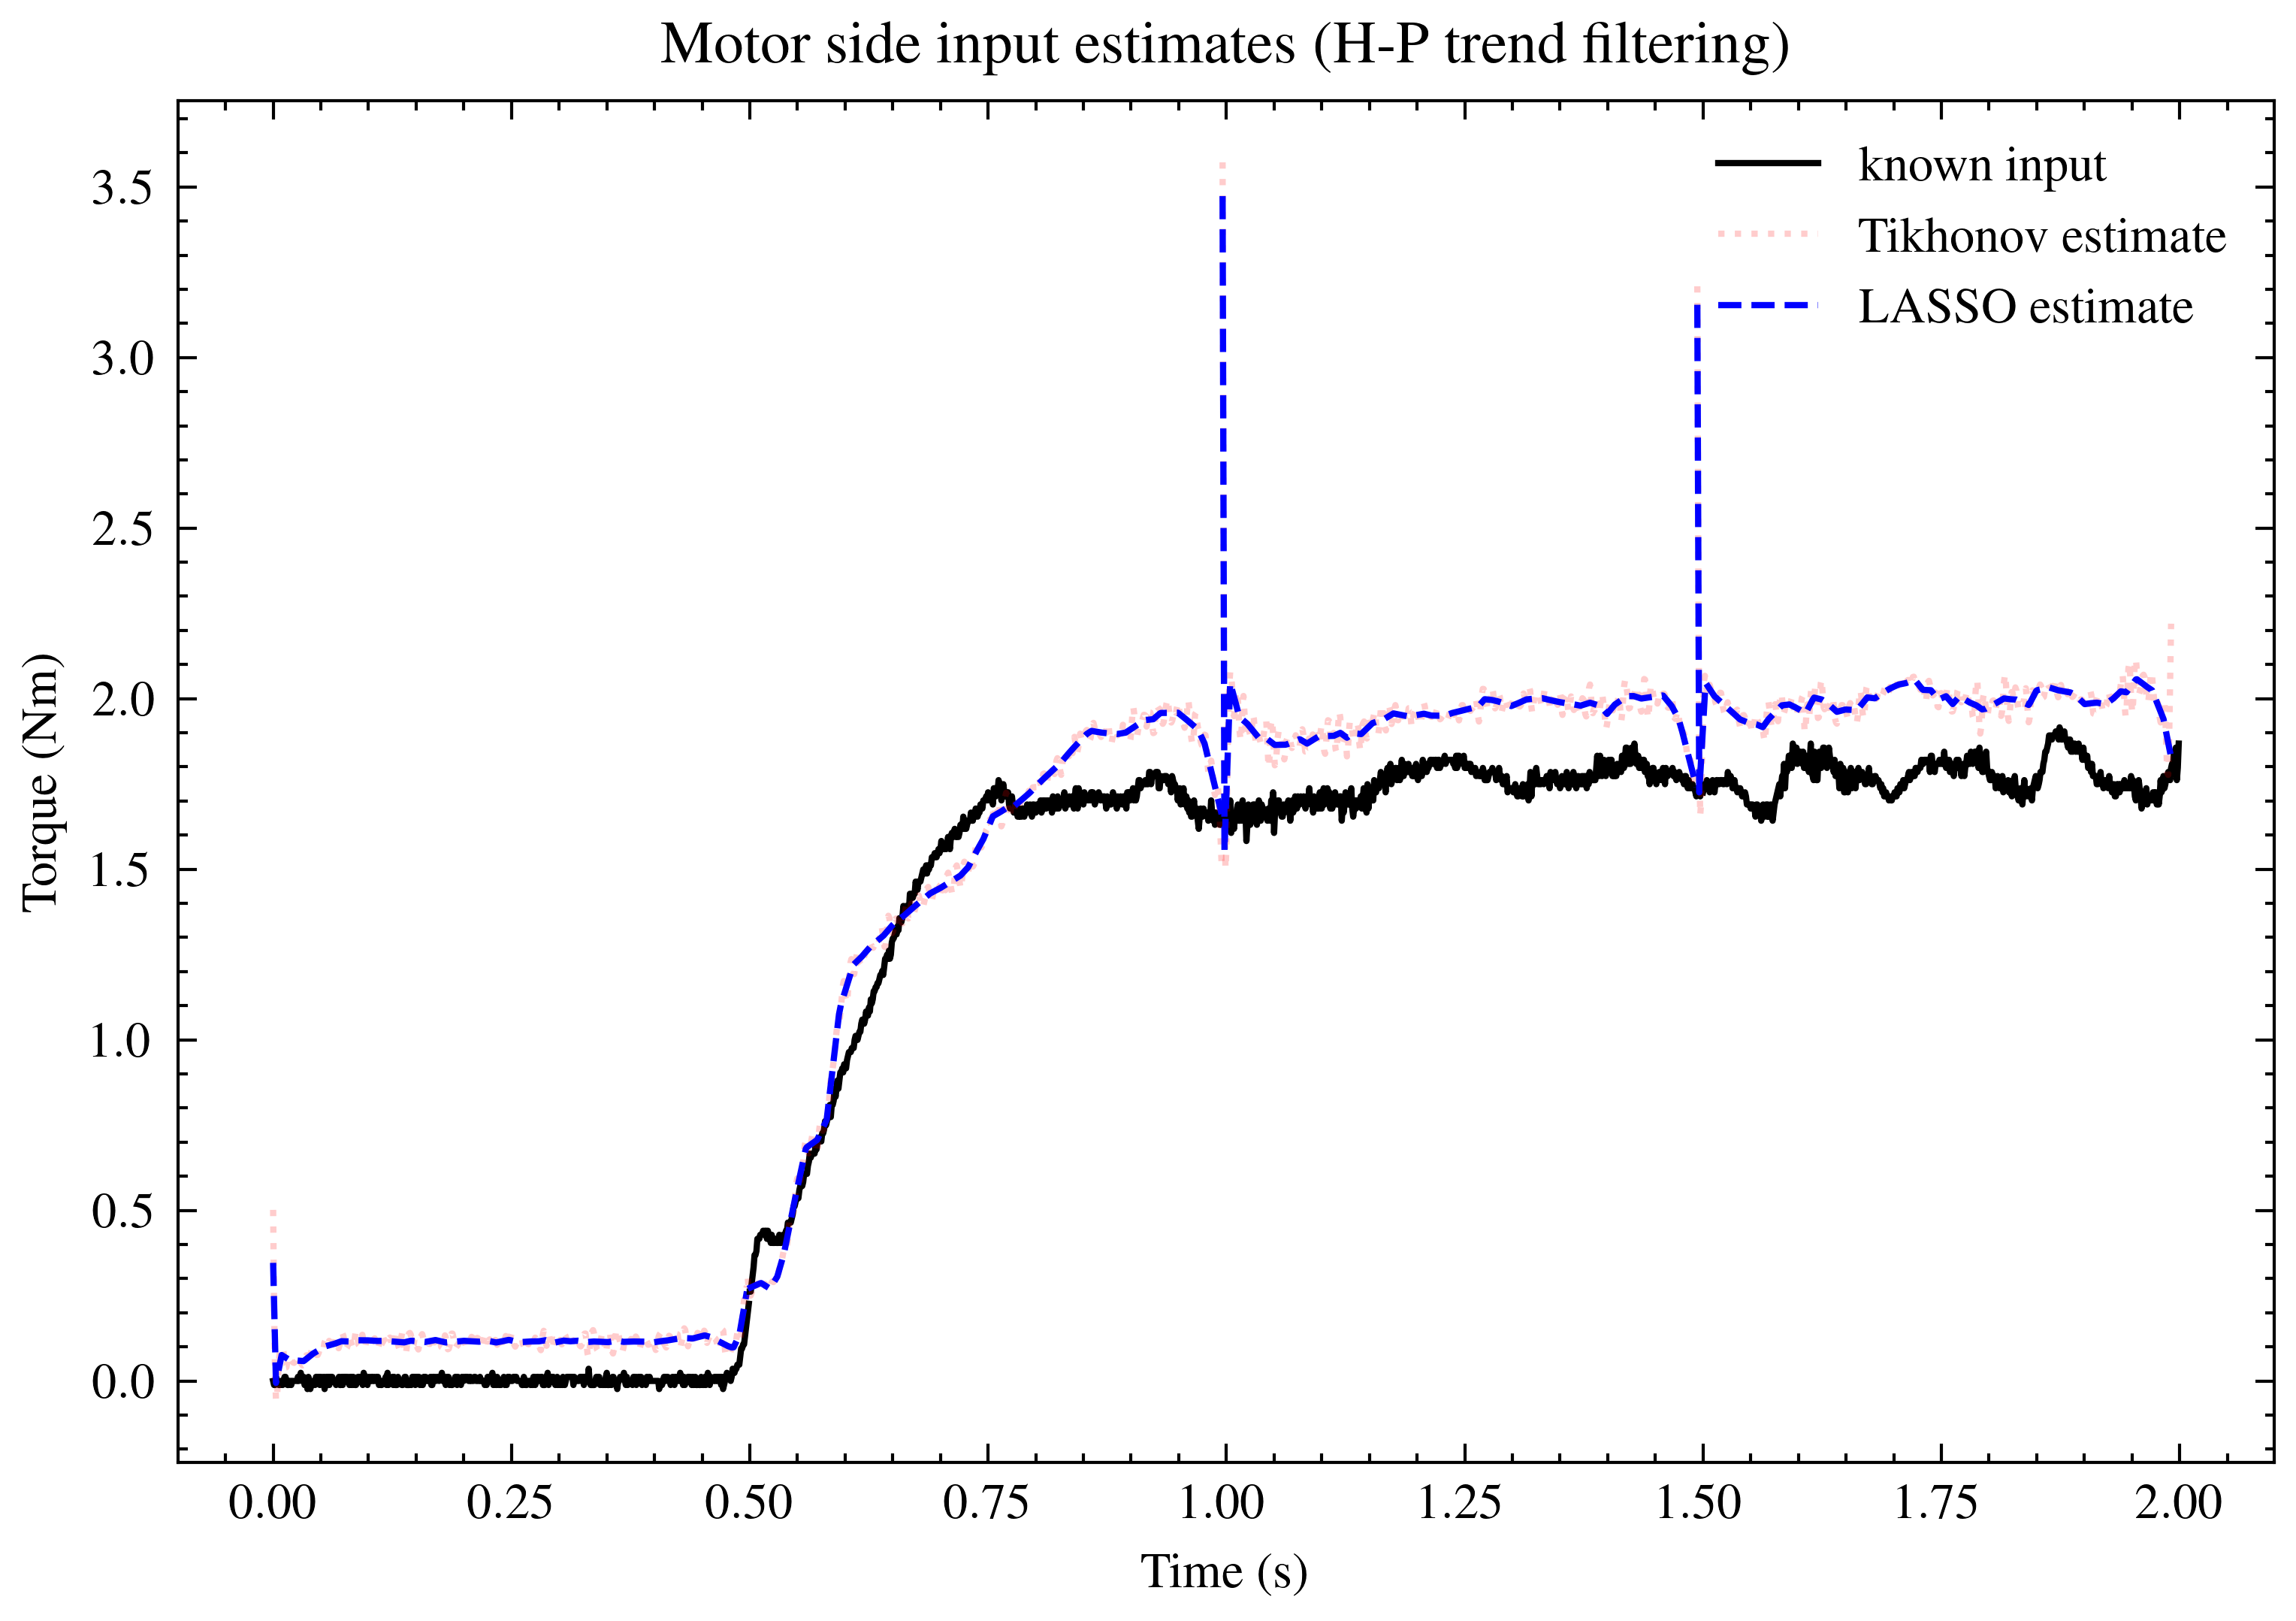

In [28]:
for i in range(loop_len):
    plt.plot(t_motor[i*bs:(i+1)*bs], tau_motor[i*bs:(i+1)*bs], linestyle='solid', color='black')
    plt.plot(t_sensor[i*bs:(i+1)*bs], tikh_estimates[i][::2], linestyle='dotted', alpha=0.2, color='red')
    plt.plot(t_sensor[i*bs:(i+1)*bs], lasso_estimates[i][::2], linestyle='dashed', color='blue')

plt.legend(('known input', 'Tikhonov estimate', 'LASSO estimate'))
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Motor side input estimates (H-P trend filtering)')
plt.show()

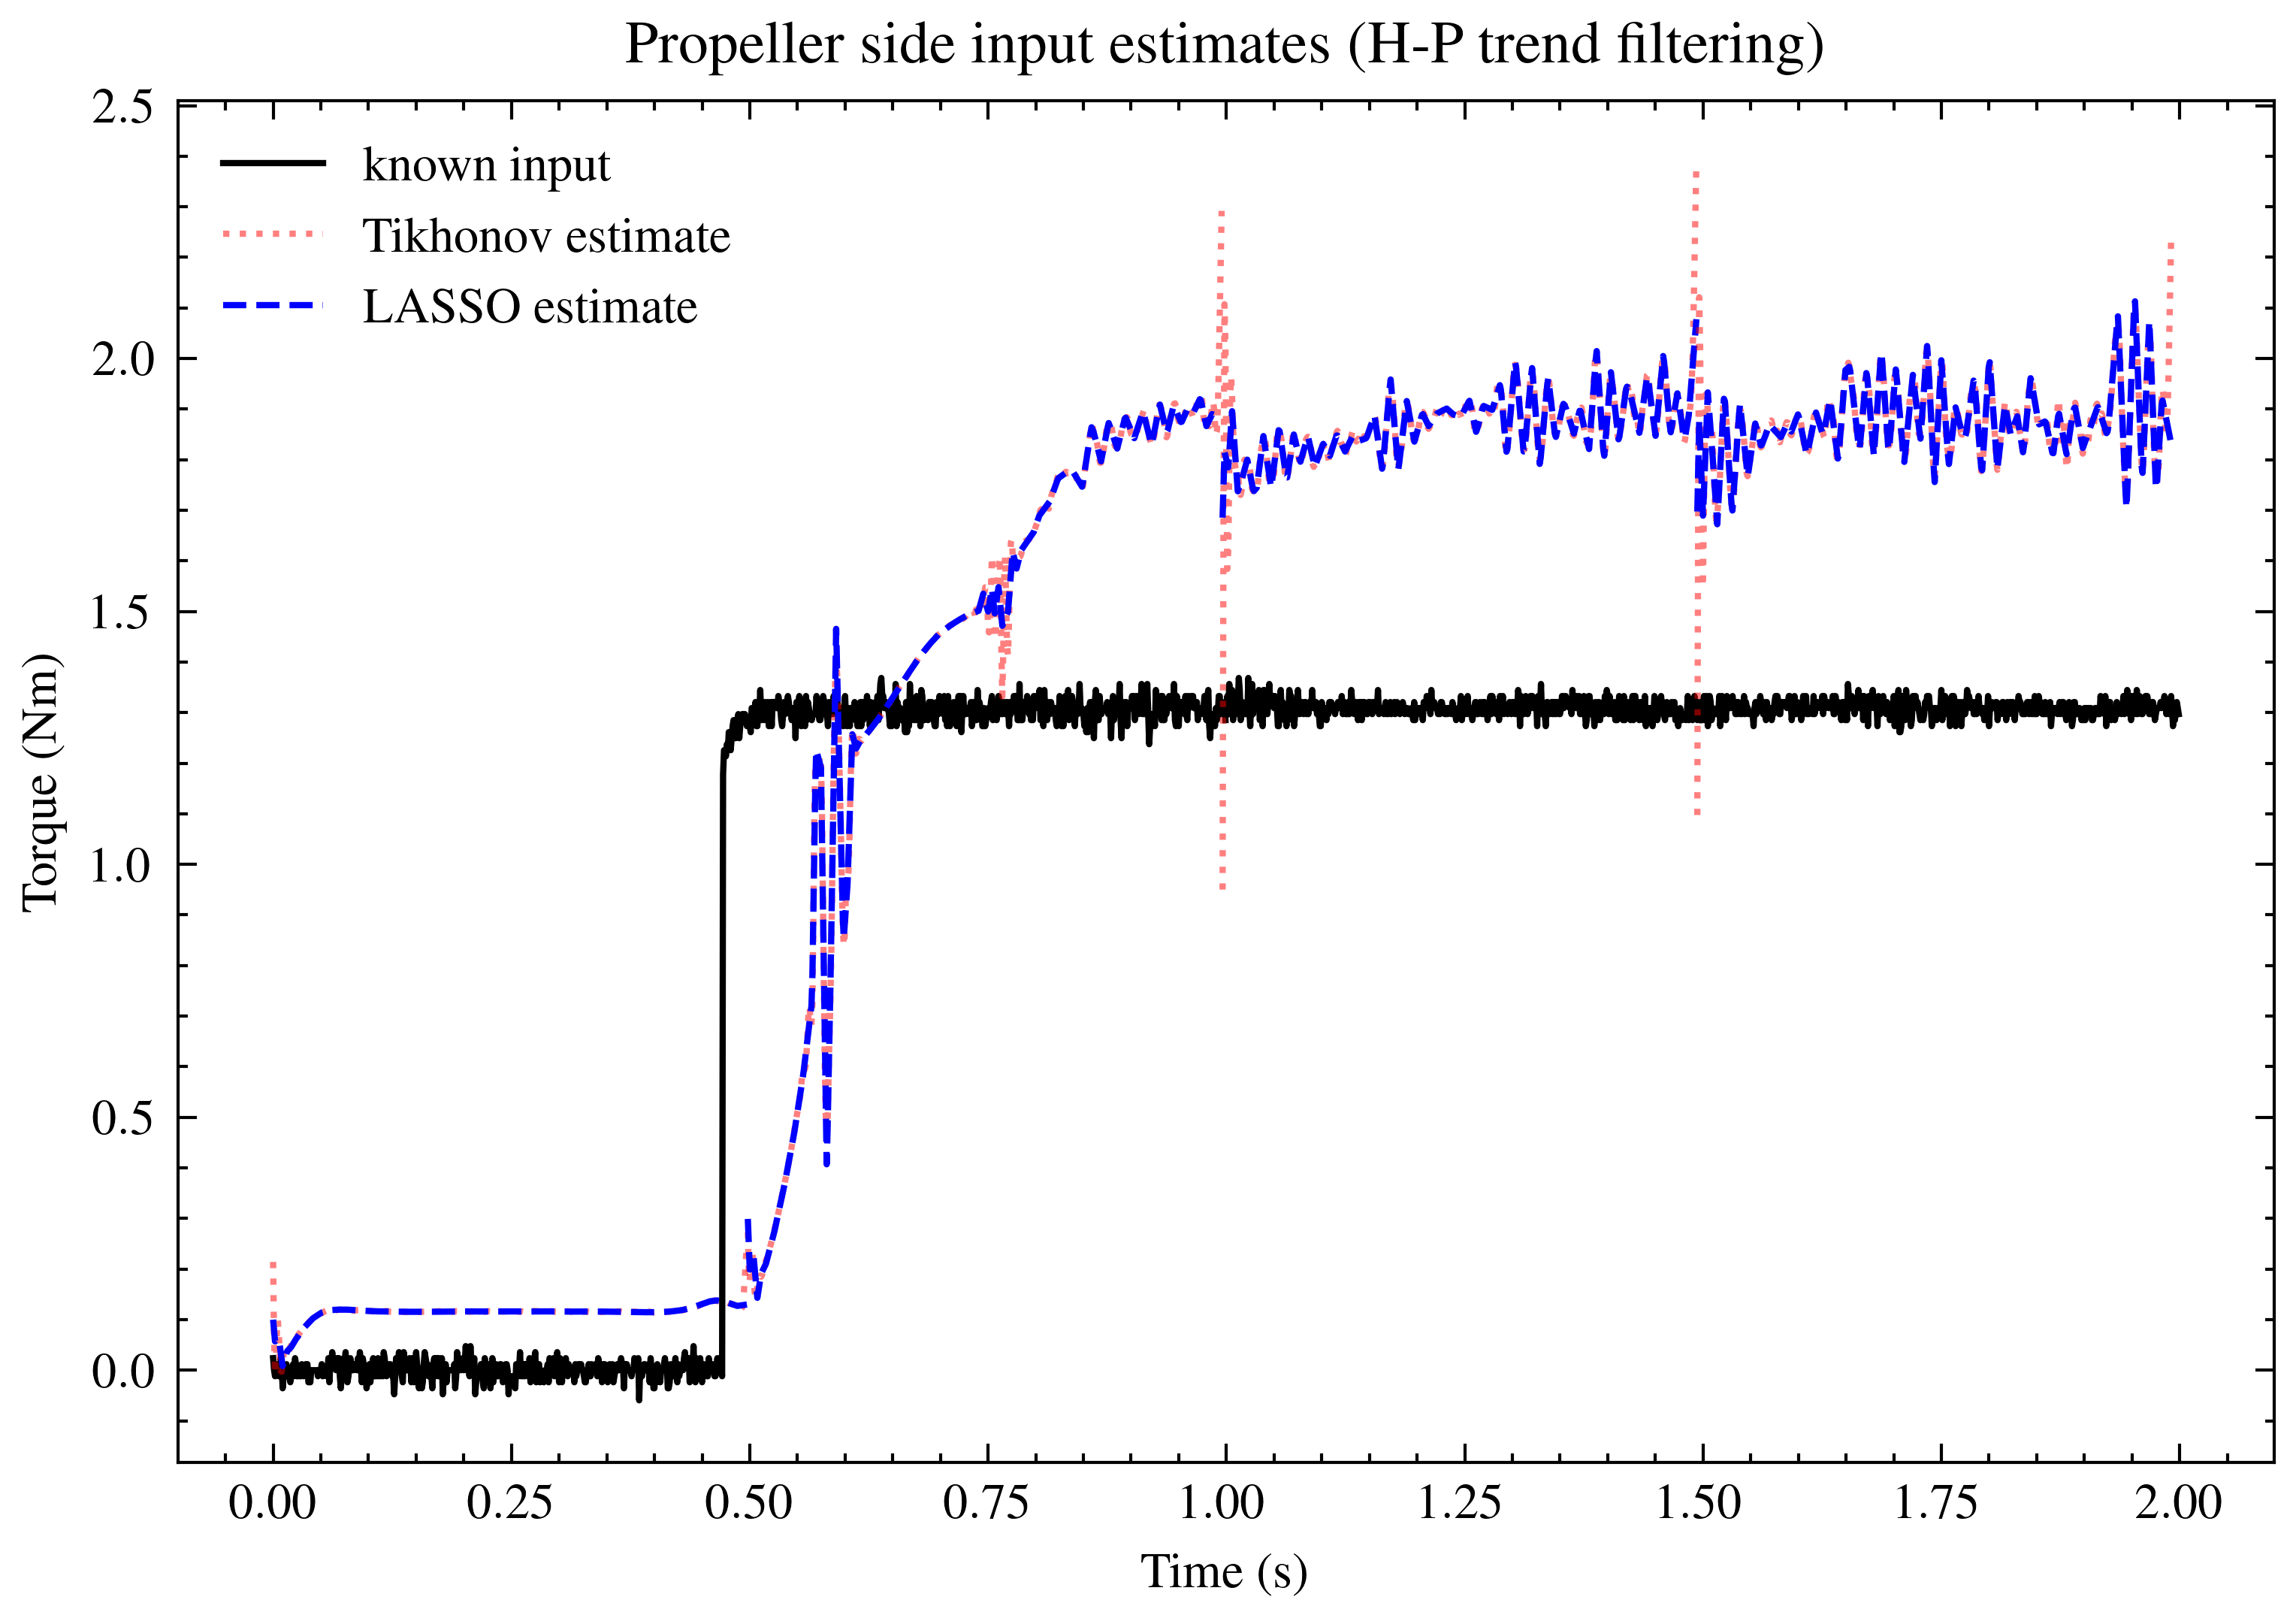

In [29]:
for i in range(loop_len):
    plt.plot(t_motor[i*bs:(i+1)*bs], tau_propeller[i*bs:(i+1)*bs], linestyle='solid', color='black')
    plt.plot(t_sensor[i*bs:(i+1)*bs], tikh_estimates[i][1::2], linestyle='dotted', alpha=0.5, color='red')
    plt.plot(t_sensor[i*bs:(i+1)*bs], lasso_estimates[i][1::2], linestyle='dashed', color='blue')

plt.legend(('known input', 'Tikhonov estimate', 'LASSO estimate'))
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Propeller side input estimates (H-P trend filtering)')
plt.show()